Ordinary Differential Equations: Conversion Reaction
============================

This example provides a model for the interconversion of two species 
($X_1$ and $X_2$) following first-order mass action kinetics with the 
parameters $\Theta_1$ and $\Theta_2$ respectively:


$$
    X_1 \rightarrow X_2, \quad\text{rate} = \Theta_1 \cdot [X_1]
$$

$$
    X_2 \rightarrow X_1, \quad\text{rate} = \Theta_2 \cdot [X_2]
$$

Measurement of $[X_2]$ is provided as $Y = [X_2]$.

We will show how to estimate $\Theta_1$ and $\Theta_2$ using pyABC.

In [1]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   ListEpsilon,
                   MedianEpsilon,
                   LocalTransition, sampler)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
import scipy as sp
import time

db_path = ("sqlite:///" +
           os.path.join("/home/felipe/testresults", "test.db"))

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{\text{true}}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 

ODE model
---------

$$
    \begin{align*}
    \frac{dX_1}{dt} &= -\Theta_1 \cdot X_1 + \Theta_2 \cdot X_2\\
    \frac{dX_2}{dt} &= \Theta_1 \cdot X_1 - \Theta_2 \cdot X_2
    \end{align*}
$$

Define the true parameters

In [2]:
theta1_true, theta2_true = np.exp([-2.5, -2])

eps_list=[10, 5, 3, 2, 1, 0.75, 0.5, 0.33, 0.25]
#eps = ListEpsilon(eps_list)
eps=MedianEpsilon(500, median_multiplier=0.8)
pop_size = 5000
expected_sleeptime_ms=1
min_eps=0.21
iters_true = 1
iters_false = 0
iters_multicore = 0
noise_factor = 0.03


and the measurement data

In [3]:
measurement_data = np.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])

as well as the time points at whith to evaluate

In [4]:
measurement_times = np.arange(len(measurement_data))

and the initial conditions for $X_1$ and $X_2$

In [5]:
init = np.array([1, 0])

Define the ODE model

In [6]:
def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],pars["theta2"]))
    x = np.random.random()
    if x >= 0.95:
        pause_ms = 1
    else:
        pause_ms = 0.1
    #pause_ms = np.random.lognormal(0,1)*(expected_sleeptime_ms/1000)
    time.sleep(pause_ms)
    return {"X_2": sol[:,1]}

Integration of the ODE model for the true parameter values

In [7]:
true_trajectory = model({"theta1": theta1_true,
                         "theta2": theta2_true})["X_2"]

Let's visualize the results

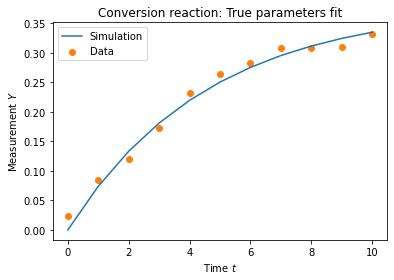

In [8]:
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In [9]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [10]:
parameter_prior = Distribution(theta1=RV("uniform", 0, 1),
                               theta2=RV("uniform", 0, 1))
parameter_prior.get_parameter_names()

['theta1', 'theta2']

In [11]:
means1 = np.zeros(iters_true)
means2 = np.zeros(iters_true)
runtimes = np.zeros(iters_true)
totalstarttime =time.time()
for i in range(0,iters_true):
    redis_sampler = sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)
    abc = ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=pop_size,
             sampler=redis_sampler,
             transitions=LocalTransition(k_fraction=.3),
             eps=eps)
    
    abc.new(db_path, {"X_2": measurement_data});
    start = time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    end = time.time()
    kekse = h.get_distribution(m=0,t=h.max_t)
    npkekse1 = kekse[0][['theta1']].to_numpy()
    npkekse2 = kekse[0][['theta2']].to_numpy()
    means1[i] = npkekse1.mean()
    means2[i] = npkekse2.mean()
    runtimes[i] = end-start

totalendtime = time.time()
walltime = totalendtime-totalstarttime

INFO:History:Start <ABCSMC(id=289, start_time=2020-11-06 19:26:21.776441, end_time=None)>
INFO:ABC:t: 0, eps: 500.


Time passed until sampling starts for generation 0 :  0.011189937591552734
Start Duration:  0.008615970611572266
Preliminary accepted: 0
Acceptance Duration:  94.27784395217896
Maybe Next Gen Duration:  2.274873733520508
Wait time:  0.000766754150390625
Preliminary discarded:  0
Collection Duration:  0.005204916000366211
Rest Duration:  0.06309342384338379
Duration of sampling for generation 0 :  96.6337206363678


INFO:ABC:Acceptance rate: 5000 / 5007 = 9.9860e-01, ESS=5.0000e+03.


History Duration:  4.806865453720093


INFO:ABC:t: 1, eps: 1.8469051655855666.


PrepNext Duration:  2.1100974082946777
Time passed until sampling starts for generation 1 :  6.946820974349976
Start Duration:  0.005093574523925781
Preliminary accepted: 143
Acceptance Duration:  238.2878839969635
Maybe Next Gen Duration:  2.150461435317993
Wait time:  0.0005819797515869141
Preliminary discarded:  0
Collection Duration:  0.0012943744659423828
Rest Duration:  0.04688525199890137
Duration of sampling for generation 1 :  240.49558782577515


INFO:ABC:Acceptance rate: 5000 / 12946 = 3.8622e-01, ESS=4.8455e+03.


History Duration:  4.766933441162109


INFO:ABC:t: 2, eps: 0.7880832947879196.


PrepNext Duration:  1.9569036960601807
Time passed until sampling starts for generation 2 :  6.7654869556427
Start Duration:  0.0057141780853271484
Preliminary accepted: 121
Acceptance Duration:  262.4050464630127
Maybe Next Gen Duration:  2.0625245571136475
Wait time:  0.0002722740173339844
Preliminary discarded:  0
Collection Duration:  0.0024237632751464844
Rest Duration:  0.0354771614074707
Duration of sampling for generation 2 :  264.5154597759247


INFO:ABC:Acceptance rate: 5000 / 14321 = 3.4914e-01, ESS=4.8332e+03.


History Duration:  4.498715877532959


INFO:ABC:t: 3, eps: 0.47520487141386775.


PrepNext Duration:  2.0872764587402344
Time passed until sampling starts for generation 3 :  6.629216194152832
Start Duration:  0.005082368850708008
Preliminary accepted: 56
Acceptance Duration:  602.2216529846191
Maybe Next Gen Duration:  2.165229558944702
Wait time:  0.0006959438323974609
Preliminary discarded:  0
Collection Duration:  0.0016295909881591797
Rest Duration:  0.03845095634460449
Duration of sampling for generation 3 :  604.4363634586334


INFO:ABC:Acceptance rate: 5000 / 32613 = 1.5331e-01, ESS=4.6761e+03.


History Duration:  4.576826333999634


INFO:ABC:t: 4, eps: 0.30385277282624407.


PrepNext Duration:  1.957664966583252
Time passed until sampling starts for generation 4 :  6.581151723861694
Start Duration:  0.005033254623413086
Preliminary accepted: 88
Acceptance Duration:  435.6083686351776
Maybe Next Gen Duration:  2.2518117427825928
Wait time:  0.00055694580078125
Preliminary discarded:  0
Collection Duration:  0.000621795654296875
Rest Duration:  0.05723977088928223
Duration of sampling for generation 4 :  437.9276611804962


INFO:ABC:Acceptance rate: 5000 / 23347 = 2.1416e-01, ESS=4.8306e+03.


History Duration:  4.814305305480957


INFO:ABC:t: 5, eps: 0.18763867458368647.


PrepNext Duration:  2.1052165031433105
Time passed until sampling starts for generation 5 :  6.963600158691406
Start Duration:  0.0051496028900146484
Preliminary accepted: 78
Acceptance Duration:  401.3137538433075


INFO:pyabc.util:Stopping: minimum epsilon.


Maybe Next Gen Duration:  0.2917146682739258
Wait time:  0.00038886070251464844
Preliminary discarded:  0
Collection Duration:  0.0015096664428710938
Rest Duration:  0.05515456199645996
Duration of sampling for generation 5 :  401.67217087745667


INFO:ABC:Acceptance rate: 5000 / 21949 = 2.2780e-01, ESS=4.9712e+03.


History Duration:  4.452816963195801


INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=289, start_time=2020-11-06 19:26:21.776441, end_time=2020-11-06 20:01:07.908314)>


PrepNext Duration:  1.9671573638916016


In [12]:
print("Results with look-ahead=True")
print("average runtime is: ",runtimes.mean(), "variance of runtimes is: ", runtimes.var())
print("total wall time for", iters_true ," repetitions: ", walltime)

Results with look-ahead=True
average runtime is:  2086.0766835212708 variance of runtimes is:  0.0
total wall time for 1  repetitions:  2086.313413143158


In [13]:
means1 = np.zeros(iters_false)
means2 = np.zeros(iters_false)
runtimes_original = np.zeros(iters_false)
totalstarttime =time.time()
for i in range(0,iters_false):
    
    redis_sampler = sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = False)
    
    abc = ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=pop_size,
             sampler=redis_sampler,
             transitions=LocalTransition(k_fraction=.3),
             eps=eps)
    
    abc.new(db_path, {"X_2": measurement_data});
    start = time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=len(eps_list))
    end = time.time()
    kekse = h.get_distribution(m=0,t=h.max_t)
    npkekse1 = kekse[0][['theta1']].to_numpy()
    npkekse2 = kekse[0][['theta2']].to_numpy()
    means1[i] = npkekse1.mean()
    means2[i] = npkekse2.mean()
    runtimes_original[i] = end-start

totalendtime = time.time()
walltime_original = totalendtime-totalstarttime

In [14]:
print("Results with look-ahead=False")
print("average runtime is: ",runtimes_original.mean(), "variance of runtimes is: ", runtimes_original.var())
print("total wall time for", iters_false ," repetitions: ", walltime_original)

Results with look-ahead=False
average runtime is:  nan variance of runtimes is:  nan
total wall time for 0  repetitions:  0.0001666545867919922


<ipython-input-14-8c94e9089e97>:2: RuntimeWarning: Mean of empty slice.
  print("average runtime is: ",runtimes_original.mean(), "variance of runtimes is: ", runtimes_original.var())
/home/felipe/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8c94e9089e97>:2: RuntimeWarning: Degrees of freedom <= 0 for slice
  print("average runtime is: ",runtimes_original.mean(), "variance of runtimes is: ", runtimes_original.var())
/home/felipe/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/felipe/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
means1 = np.zeros(iters_multicore)
means2 = np.zeros(iters_multicore)
runtimes_multicore= np.zeros(iters_multicore)
totalstarttime =time.time()
for i in range(0,iters_multicore):
    abc = ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=50,
             transitions=LocalTransition(k_fraction=.3),
             eps=eps)
    abc.new(db_path, {"X_2": measurement_data});
    start = time.time()
    h = abc.run(minimum_epsilon=min_eps, max_nr_populations=5)
    end = time.time()
    kekse = h.get_distribution(m=0,t=h.max_t)
    npkekse1 = kekse[0][['theta1']].to_numpy()
    npkekse2 = kekse[0][['theta2']].to_numpy()
    means1[i] = npkekse1.mean()
    means2[i] = npkekse2.mean()
    runtimes_multicore[i] = end-start

totalendtime = time.time()
walltime_multicore = totalendtime-totalstarttime

In [16]:
print("Results for Multicore-Sampler")
print("average runtime is: ",runtimes_multicore.mean(), "variance of runtimes is: ", runtimes_multicore.var())
print("total wall time for", iters_multicore ," repititions: ", walltime_multicore)

Results for Multicore-Sampler
average runtime is:  nan variance of runtimes is:  nan
total wall time for 0  repititions:  0.00015401840209960938


<ipython-input-16-36980f3ce7cc>:2: RuntimeWarning: Mean of empty slice.
  print("average runtime is: ",runtimes_multicore.mean(), "variance of runtimes is: ", runtimes_multicore.var())
<ipython-input-16-36980f3ce7cc>:2: RuntimeWarning: Degrees of freedom <= 0 for slice
  print("average runtime is: ",runtimes_multicore.mean(), "variance of runtimes is: ", runtimes_multicore.var())


In [17]:
"""
iters = 10
means1 = np.zeros(iters)
means2 = np.zeros(iters)
runtimes_one = np.zeros(iters)
totalstarttime =time.time()
for i in range(0,iters):
    eps_list=[4, 2, 1, 0.5, 0.25]
    eps = ListEpsilon(eps_list)
    redis_sampler = sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)
    abc = ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=50,
             sampler=redis_sampler,
             transitions=LocalTransition(k_fraction=.3),
             eps=eps)
    
    abc.new(db_path, {"X_2": measurement_data});
    start = time.time()
    h = abc.run(minimum_epsilon=0.1, max_nr_populations=len(eps_list))
    end = time.time()
    kekse = h.get_distribution(m=0,t=h.max_t)
    npkekse1 = kekse[0][['theta1']].to_numpy()
    npkekse2 = kekse[0][['theta2']].to_numpy()
    means1[i] = npkekse1.mean()
    means2[i] = npkekse2.mean()
    runtimes_one[i] = end-start

totalendtime = time.time()
walltime_one = totalendtime-totalstarttime
"""

'\niters = 10\nmeans1 = np.zeros(iters)\nmeans2 = np.zeros(iters)\nruntimes_one = np.zeros(iters)\ntotalstarttime =time.time()\nfor i in range(0,iters):\n    eps_list=[4, 2, 1, 0.5, 0.25]\n    eps = ListEpsilon(eps_list)\n    redis_sampler = sampler.RedisEvalParallelSampler(host="localhost", port=6379, look_ahead = True)\n    abc = ABCSMC(models=model,\n             parameter_priors=parameter_prior,\n             distance_function=distance,\n             population_size=50,\n             sampler=redis_sampler,\n             transitions=LocalTransition(k_fraction=.3),\n             eps=eps)\n    \n    abc.new(db_path, {"X_2": measurement_data});\n    start = time.time()\n    h = abc.run(minimum_epsilon=0.1, max_nr_populations=len(eps_list))\n    end = time.time()\n    kekse = h.get_distribution(m=0,t=h.max_t)\n    npkekse1 = kekse[0][[\'theta1\']].to_numpy()\n    npkekse2 = kekse[0][[\'theta2\']].to_numpy()\n    means1[i] = npkekse1.mean()\n    means2[i] = npkekse2.mean()\n    runtimes_

In [18]:
"""
print("Results with only one worker:")
print("average runtime is: ",runtimes_one.mean(), "variance of runtimes is: ", runtimes_one.var())
print("total wall time for", iters ," repetitions: ", walltime_one)
"""

'\nprint("Results with only one worker:")\nprint("average runtime is: ",runtimes_one.mean(), "variance of runtimes is: ", runtimes_one.var())\nprint("total wall time for", iters ," repetitions: ", walltime_one)\n'